<a href="https://colab.research.google.com/github/Puja176/Intelligent-Cyber-Sec/blob/master/Membership_Attack1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# required imports
import sys 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline  


import torch
import torchvision 
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
# mount the google drive to download the datasets
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/My Drive/UMKC/Cybersecurity/ICP-66'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# create transforms to load the images, nothing much is needed here. 
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [0]:
# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [0]:
# download CIFAR 10 training set
trainset = torchvision.datasets.STL10(root= project_path+'/data', 
                                        split='train' ,download=True, transform=transform_train)

# load the trainning set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# download the test data
testset = torchvision.datasets.STL10(root= project_path+'/data', 
                                        split='test',download=True, transform=transform_test)

# load the test data
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)

classes = ('whale', 'shark', 'roses', 'cans', 'oranges', 'lamp', 'table', 'butterfly', 'lion', 'house')
# check those manually on the dataset site: https://www.cs.toronto.edu/~kriz/cifar.html

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


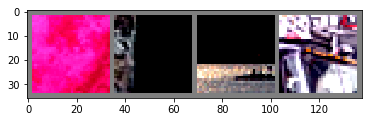

In [0]:
# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(imgs)) 

# notice who we converted the class idx to labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# run this cell multiple times and notice diff images

In [0]:
# divide the training dataset into the required groups Make sure they are balanced
# original trainset is made of 50k images

total_size = len(trainset)
split1 = total_size // 4
split2 = split1 * 2
split3 = split1 * 3

print(total_size, split1, split2, split3)

indices = list(range(total_size))

# two groups to train the shadow (in and out)
shadow_train_idx = indices[:split1]
shadow_out_idx = indices[split1:split2]

# two groups to train the Target (in and out)
target_train_idx = indices[split2:split3]
target_out_idx =  indices[split3:]

5000 1250 2500 3750


In [0]:
batch_size = 16# pick your own

# divide and load shadow train in and out
shadow_train_sampler = SubsetRandomSampler(shadow_train_idx) # Pytorch function
shadow_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_train_sampler)

shadow_out_sampler = SubsetRandomSampler(shadow_out_idx) # Pytorch function
shadow_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_out_sampler)

# divide and load Target in and out
target_train_sampler = SubsetRandomSampler(target_train_idx) # Pytorch function
target_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_train_sampler)

target_out_sampler = SubsetRandomSampler(target_out_idx) # Pytorch function
target_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_out_sampler)

In [0]:

#@title
# create a CNN
# Input shape (3, 32, 32) 
# architecture: simple. 2 conv and 2 Max pool, followed by 2 fc (120, 84) 
# output of fc is 10 because we have 10 classes!



class CNN(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10),
            nn.LogSoftmax(dim=1)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [0]:
# check if CUDA available or not
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
# clear the cache
torch.cuda.empty_cache()

True
Tesla T4


In [0]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = CNN()
    model.load_state_dict(checkpoint)
    
    return model

In [0]:
# initalize a Shadow Model and Train it
# for the first ICP, your shadow model can have the same CNN architecture and hyperparameters

shadow_model = CNN()
# clear the cache
torch.cuda.empty_cache()
#send to GPU
shadow_model = shadow_model.cuda()
shadow_criterion =  nn.CrossEntropyLoss() # CrossEntropyLoss
shadow_optimizer = optim.Adam(shadow_model.parameters(), lr=0.0003) # ADAM 


# let the magic begin
epochs = 20
with torch.set_grad_enabled(True):
  for e in range(epochs):
      running_loss = 0
      for images, labels in shadow_train_loader:
          # sending tensors to GPU
          images = images.cuda()
          labels = labels.cuda()
          shadow_optimizer.zero_grad()
          logits = shadow_model(images)
          shadow_loss = shadow_criterion(logits, labels)
          shadow_loss.backward()
          shadow_optimizer.step()


          running_loss += shadow_loss.item()
      else:
          print("\nEpoch : {}/{}..".format(e+1,epochs),f"Training loss: {running_loss/len(shadow_train_loader)}")

#save the model
print("Our model: \n\n", shadow_model, '\n')
torch.save(shadow_model.state_dict(), project_path+'/shadow1_checkpoint.pth')
print('Finished Training the Shadow model')


Epoch : 1/20.. Training loss: 2.2397332704519926

Epoch : 2/20.. Training loss: 2.1108391405660893

Epoch : 3/20.. Training loss: 2.04982962638517

Epoch : 4/20.. Training loss: 2.01755137684979

Epoch : 5/20.. Training loss: 2.0349248285535015

Epoch : 6/20.. Training loss: 2.0125163401229473

Epoch : 7/20.. Training loss: 1.9996690327608133

Epoch : 8/20.. Training loss: 1.9504621360875383

Epoch : 9/20.. Training loss: 1.9365346990054166

Epoch : 10/20.. Training loss: 1.9292624962480762

Epoch : 11/20.. Training loss: 1.9621957706499704

Epoch : 12/20.. Training loss: 1.927135381517531

Epoch : 13/20.. Training loss: 1.9054679463181314

Epoch : 14/20.. Training loss: 1.9198198997521703

Epoch : 15/20.. Training loss: 1.899045541316648

Epoch : 16/20.. Training loss: 1.9369235114206242

Epoch : 17/20.. Training loss: 1.9138198668443704

Epoch : 18/20.. Training loss: 1.892343693141696

Epoch : 19/20.. Training loss: 1.906880882721913

Epoch : 20/20.. Training loss: 1.90989550910418

In [0]:

# calculate the accuracy of the Shadow Model
correct = 0
total = 0

with torch.no_grad():
    for images, labels in shadow_out_loader:
        # sending tensors to GPU
        images = images.cuda()
        labels = labels.cuda()
        outputs = shadow_model(images)
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 12500 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 12500 test images: 25 %


In [0]:
batch_size = 1# pick your own

# divide and load shadow train in and out
shadow_train_sampler = SubsetRandomSampler(shadow_train_idx) # Pytorch function
shadow_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_train_sampler)

shadow_out_sampler = SubsetRandomSampler(shadow_out_idx) # Pytorch function
shadow_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_out_sampler)

# divide and load Target in and out
target_train_sampler = SubsetRandomSampler(target_train_idx) # Pytorch function
target_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_train_sampler)

target_out_sampler = SubsetRandomSampler(target_out_idx) # Pytorch function
target_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_out_sampler)

In [0]:
#load the model
load_shadow_model = load_checkpoint(project_path+'/shadow1_checkpoint.pth')
load_shadow_model = load_shadow_model.cuda()

# freeze the Shadow model 
for param in load_shadow_model.parameters():
    param.requires_grad = False
    
# make predictions on both datasets (shadow_in and shdow_out)
predictions = []

labels_0 = 0#np.zeros(1)
labels_1 = 1#np.ones(1)

with torch.no_grad():
    for images, labels in shadow_train_loader:
        # sending tensors to GPU
        images = images.cuda()
        labels = labels.cuda()
        logps = load_shadow_model(images)
        ps = torch.exp(logps) 
        ps = ps.cpu()
        pred = ps.data.numpy()
        predictions.append([pred[0],labels_1])   
with torch.no_grad():
    for images, labels in shadow_out_loader:
        # sending tensors to GPU
        images = images.cuda()
        labels = labels.cuda()
        logps = load_shadow_model(images)
        ps = torch.exp(logps) 
        ps = ps.cpu()
        pred = ps.data.numpy()
        predictions.append([pred[0],labels_0]) 
        
print(predictions[0])  
print(predictions[2000])

[array([0.09056915, 0.17454015, 0.04508923, 0.11724278, 0.10316083,
       0.13473624, 0.1071687 , 0.10118535, 0.05865627, 0.06765126],
      dtype=float32), 1]
[array([0.1371661 , 0.10821615, 0.14031759, 0.06336891, 0.05353362,
       0.07685729, 0.08907619, 0.05861205, 0.12900916, 0.14384304],
      dtype=float32), 0]


In [0]:
import pickle

with open(project_path+'/data/shadow1.data', 'wb') as filehandle:
    pickle.dump(predictions, filehandle)

In [0]:
# calculate the recall and precision of your attack network using the Target_out and Target_in datasets
# to do so, take a random numer of datapoints, run them throw the target model,
#load the model
load_target_model = load_checkpoint(project_path+'/shadow1_checkpoint.pth')
load_target_model = load_target_model.cuda()

# freeze the Shadow model 
for param in load_target_model.parameters():
    param.requires_grad = False
    
# make predictions on both datasets (shadow_in and shdow_out)
predictions = []
label_size = (1,1)

labels_0 = 0
labels_1 = 1
with torch.no_grad():
    for images, labels in target_train_loader:
        # sending tensors to GPU
        images = images.cuda()
        labels = labels.cuda()
        logps = load_target_model(images)
        ps = torch.exp(logps) 
        ps = ps.cpu()
        pred = ps.data.numpy()
        predictions.append([pred[0],labels_1])   
with torch.no_grad():
    for images, labels in target_out_loader:
        # sending tensors to GPU
        images = images.cuda()
        labels = labels.cuda()
        logps = load_target_model(images)
        ps = torch.exp(logps) 
        ps = ps.cpu()
        pred = ps.data.numpy()
        predictions.append([pred[0],labels_0]) 
        
#save the dataset
import pickle

with open(project_path+'/data/target1.data', 'wb') as filehandle:
    pickle.dump(predictions, filehandle)

In [0]:
#load the dataset
with open(project_path+'/data/target1.data', 'rb') as filehandle:
    # read the data as binary data stream
    testloader = pickle.load(filehandle)

In [0]:
#load the dataset
with open(project_path+'/data/shadow1.data', 'rb') as filehandle:
    # read the data as binary data stream
    predictionsList = pickle.load(filehandle)

In [0]:
total_size = len(predictionsList)
split1 = total_size // 4
split1 = total_size - split1 
split2 = split1*2
indices = list(range(total_size))

# two groups to train the shadow (in and out)
train_idx = indices[:] 
test_idx = indices[split1:] 
print(f'No.of train date {len(train_idx)} and No.of test data {len(test_idx)}')
batch_size = 10 # pick your own

# divide and load shadow train in and out
train_sampler = SubsetRandomSampler(train_idx) # Pytorch function
train_loader = torch.utils.data.DataLoader(predictionsList, batch_size=batch_size, sampler=train_sampler)

test_sampler = SubsetRandomSampler(test_idx) # Pytorch function
test_loader = torch.utils.data.DataLoader(predictionsList, batch_size=batch_size, sampler=test_sampler)

No.of train date 2500 and No.of test data 625


In [0]:
# create the Attack Model: A NN binary classifier {0, 1}
# the input to this model is the propability distribution vector of size 10
# and the output is either 0 (input was not included in training) or 1
from torch.autograd import Variable
attack_model = nn.Sequential(nn.Linear(10, 20),
                      nn.ReLU(),
                      nn.Linear(20, 26),
                      nn.ReLU(),
                      nn.Linear(26, 16),
                      nn.ReLU(),
                      nn.Linear(16, 8),
                      nn.ReLU(),
                      nn.Linear(8, 2),
                      nn.LogSoftmax(dim=1))
attack_model = attack_model.cuda()
attack_criterion = nn.CrossEntropyLoss()
attack_optimizer = optim.Adam(attack_model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for outputs, labels in train_loader:
        # sending tensors to GPU
        outputs = outputs.cuda().float()
        labels = labels.cuda().long()
        attack_optimizer.zero_grad()
        pred = torch.exp(attack_model(outputs))
        #print(pred.data, labels)
        loss = attack_criterion(pred, labels)
        loss.backward()
        attack_optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(predictionsList)}")
        
torch.save(attack_model.state_dict(), project_path+'/attack1_checkpoint.pth')
print('Finished Training the Attack model')

Training loss: 0.06941141719818116
Training loss: 0.06935809502601624
Training loss: 0.06937127656936645
Training loss: 0.0693600853919983
Training loss: 0.0693547751903534
Finished Training the Attack model


In [0]:
#load the dataset
with open(project_path+'/data/target1.data', 'rb') as filehandle:
    # read the data as binary data stream
    validation = pickle.load(filehandle)

In [0]:
batch_size = 1 # pick your own

validation_sampler = SubsetRandomSampler(indices[500:2500]) # randomly picking 5000 data items
validation_loader = torch.utils.data.DataLoader(validation, batch_size=batch_size, sampler=validation_sampler)

In [0]:
#input the output of the target model to your attack network 
# you already know the target_in and target_out samples, so use that info to evaluate the attack model
correct = 0
incorrect = 0
total = 0
tp = 0
tn = 0
fp = 0
fn = 0
with torch.no_grad():
    for outputs, labels in validation_loader:
        # sending tensors to GPU
        outputs = outputs.cuda().float()
        labels = labels.cuda().long()
        pred = torch.exp(attack_model(outputs))
        predicted = torch.argmax(pred.data)
        #print('\n',pred.data, predicted)
        total += labels.size(0)
        correct += (predicted.item() == labels.item())
        tp += ((predicted.item() == labels.item()) and (predicted.item() == 1))
        tn += ((predicted.item() == labels.item()) and (predicted.item() == 0))
        fp += ((predicted.item() != labels.item()) and (predicted.item() == 1))
        fn += ((predicted.item() != labels.item()) and (predicted.item() == 0))
incorrect = total- correct
print(f'TP : {tp}, TN : {tn}, FP : {fp}, FN : {fn}')
if((tp+fp)!=0):
  pre = tp/(tp+fp)
if((tp+fn)!=0):
  rec = tp/(tp+fn)
print(f'Precision {pre*100}')
print(f'Recall {rec*100}')
print(f'F1 Score {2*((pre*rec)/(pre+rec))*100}')

TP : 750, TN : 0, FP : 1250, FN : 0
Precision 37.5
Recall 100.0
F1 Score 54.54545454545454
